In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torchvision.transforms import ToPILImage
from hybrid_cnn import HybridCNN, DBSR, CustomDBSRDataset, get_dataloaders, RSEEnhancer


In [2]:
dataset_loader = '/home/idrone2/Tea_pest/pest_class'

In [3]:
train_loader, test_loader = get_dataloaders(
    folder_path = dataset_loader,
    target_size=(224, 224),
    dbsr_blocks=4,
    batch_size=32,
    augment=True,
    enhance=True,
    split_ratio=0.8
)



In [33]:
num_classes = len(train_loader.dataset.dataset.classes)

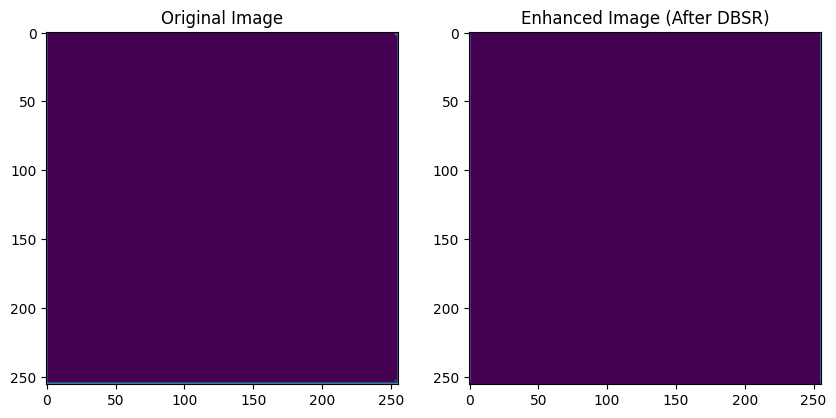

In [34]:
# Initialize DBSR model for enhancing images
dbsr_model = DBSR(num_blocks=4).to('cuda' if torch.cuda.is_available() else 'cpu')
dbsr_model.eval()  # Set DBSR model to evaluation mode

# Function to denormalize an image (if normalization was applied)
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # scale by std and add mean
    return tensor

# Function to convert tensor to PIL image for visualization
def tensor_to_image(tensor):
    to_pil = ToPILImage()
    return to_pil(tensor.cpu())

# Randomly pick an image from the dataset
batch = random.choice(train_loader.dataset)  # Random image from dataset
image, label = batch

# Denormalize the image if it was normalized (adjust mean and std if different)
mean = [0.485, 0.456, 0.406]  # Common ImageNet mean
std = [0.229, 0.224, 0.225]   # Common ImageNet std
image_denorm = denormalize(image.clone(), mean, std)  # Clone to avoid modifying original

# Add batch dimension and move to GPU if available
image = image.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')

# Apply DBSR to enhance image resolution
with torch.no_grad():
    enhanced_image = dbsr_model(image)


enhanced_imagen=image_denorm.clone()
# Convert enhanced image back to CPU for visualization
enhanced_image = enhanced_image.squeeze(0)  # Remove batch dimension
enhanced_image = denormalize(enhanced_image.clone(), mean, std)

# Visualize the original and enhanced images side by side
original_image = tensor_to_image(image_denorm[0])
enhanced_image = tensor_to_image(enhanced_image[0])

# Plotting the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(enhanced_image)
axes[1].set_title("Enhanced Image (After DBSR)")
plt.show()

In [ ]:
# Create a DataFrame to show the size comparison
data = {
    'Batch': list(range(len(original_sizes))),
    'Original Size (H x W)': [f"{size[2]} x {size[3]}" for size in original_sizes],
    'Enhanced Size (H x W)': [f"{size[2]} x {size[3]}" for size in enhanced_sizes],
}

size_df = pd.DataFrame(data)

# Show the DataFrameProfile
print("\nComparative Sizes of Images (Before and After DBSR Enhancement):")
print(size_df)

# # Optionally, visualize the size comparison
# size_df.plot(kind='bar', x='Batch', title='Image Sizes Before and After DBSR Enhancement')
# plt.ylabel('Height x Width')
# plt.xticks(rotation=0)
# plt.show()


Comparative Sizes of Images (Before and After DBSR Enhancement):
   Batch Original Size (H x W) Enhanced Size (H x W)
0      0             256 x 256             256 x 256


In [36]:
# Now we implement the training logic for HybridCNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridCNN(num_classes = num_classes).to(device)  # Make sure HybridCNN is defined properly
criterion = nn.CrossEntropyLoss()  # Choose an appropriate loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Set up the optimizer


In [37]:
 #Training Loop Settings
epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training and validation loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Validation phase
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in test_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)

            # Track validation loss and accuracy
            val_loss += loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

    # Calculate validation loss and accuracy
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val * 100

    # Logging
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')


Epoch [1/20], Train Loss: 1.0874, Train Acc: 52.31%, Val Loss: 1.9805, Val Acc: 23.71%
Epoch [2/20], Train Loss: 0.9578, Train Acc: 59.64%, Val Loss: 14.7621, Val Acc: 23.57%
Epoch [3/20], Train Loss: 0.9287, Train Acc: 60.56%, Val Loss: 11.7268, Val Acc: 27.57%
Epoch [4/20], Train Loss: 0.8773, Train Acc: 63.14%, Val Loss: 7.1336, Val Acc: 21.43%
Epoch [5/20], Train Loss: 0.8943, Train Acc: 62.07%, Val Loss: 2.0145, Val Acc: 48.71%
Epoch [6/20], Train Loss: 0.8642, Train Acc: 63.78%, Val Loss: 3.5219, Val Acc: 26.29%
Epoch [7/20], Train Loss: 0.8445, Train Acc: 64.43%, Val Loss: 3.1519, Val Acc: 16.43%
Epoch [8/20], Train Loss: 0.8474, Train Acc: 65.28%, Val Loss: 1.8270, Val Acc: 27.71%
Epoch [9/20], Train Loss: 0.8258, Train Acc: 65.68%, Val Loss: 3.6000, Val Acc: 27.43%
Epoch [10/20], Train Loss: 0.7896, Train Acc: 65.71%, Val Loss: 14.5804, Val Acc: 27.43%
Epoch [11/20], Train Loss: 0.7997, Train Acc: 66.82%, Val Loss: 2.0782, Val Acc: 30.57%
Epoch [12/20], Train Loss: 0.7971, Tra

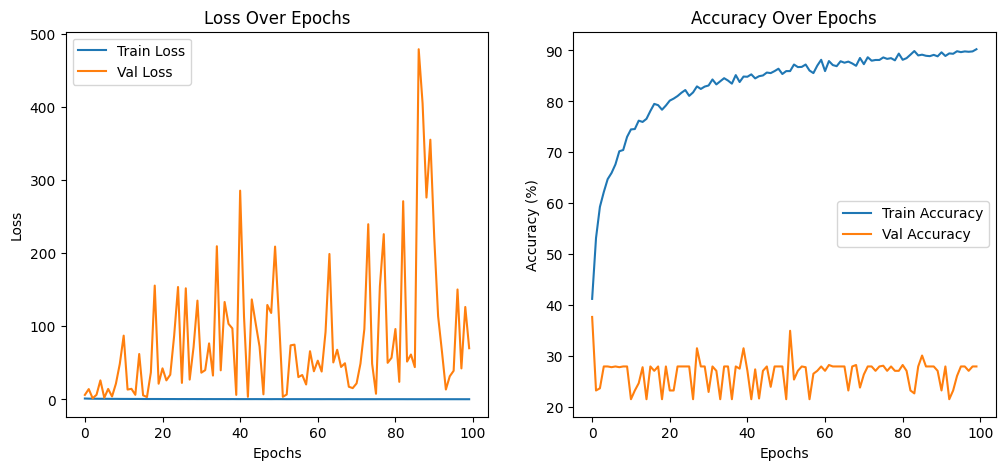

In [19]:
# Plotting training and validation loss/accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

<Figure size 1000x800 with 0 Axes>

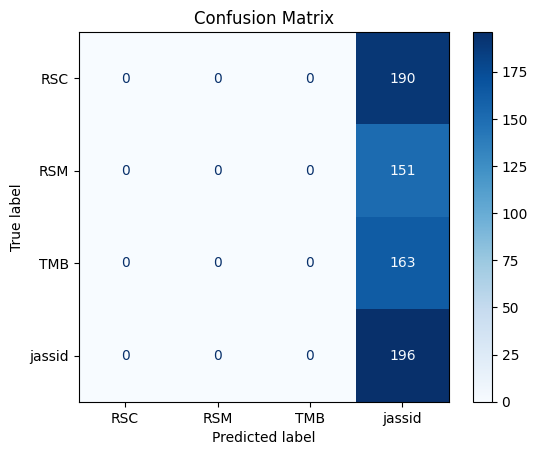

In [20]:
# Confusion Matrix for validation set
all_preds = []
all_labels = []

model.eval()  # Set model to eval mode for inference
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=train_loader.dataset.dataset.classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Selected image: /home/idrone2/Tea_pest/pest_class/TMB/GOPR8560.JPG
Original Image - Resolution: 4000x3000, Mean BGR: [ 84.00383275 135.37359683 102.47825083], Std BGR: [47.17142185 49.66510795 39.73251965]
Enhanced Image - Resolution: 4000x3000, Mean BGR: [ 98.91007133 155.55055608 119.78765425], Std BGR: [71.71164842 73.64505885 66.05055387]


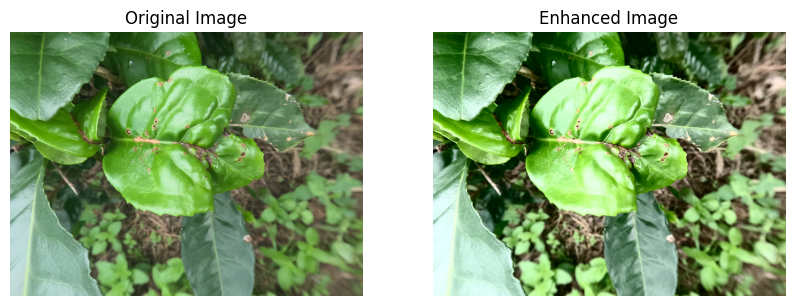

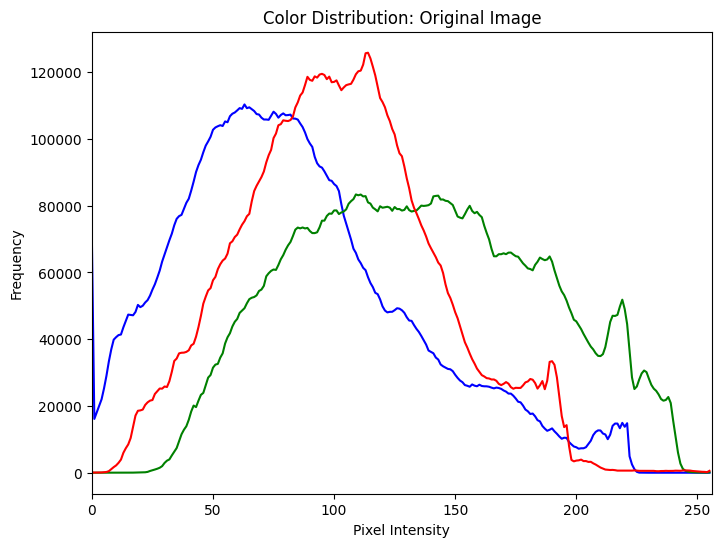

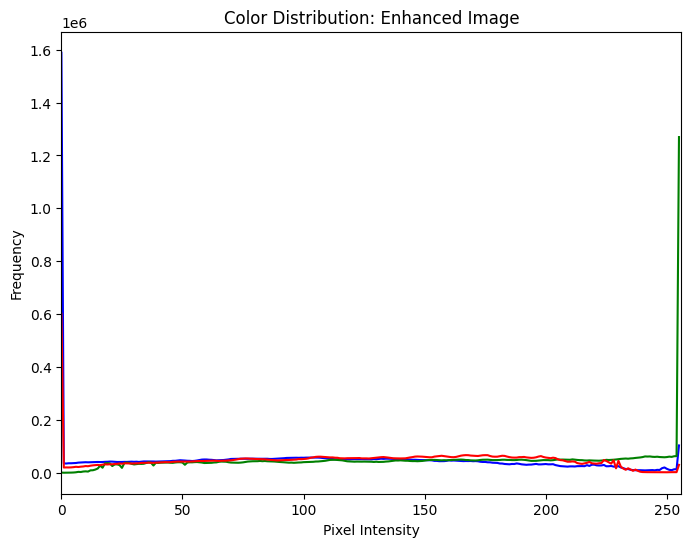

In [10]:
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
from torchvision.datasets import ImageFolder
from hybrid_cnn.hybrid_dbsr import RSEEnhancer  # Assuming you have imported the correct path

# Function to calculate statistics
def calculate_statistics(image):
    # Get image dimensions (resolution)
    height, width, _ = image.shape
    
    # Calculate mean and standard deviation for each color channel (BGR in OpenCV)
    mean_bgr = np.mean(image, axis=(0, 1))  # Mean of BGR channels
    std_bgr = np.std(image, axis=(0, 1))    # Std of BGR channels
    
    return height, width, mean_bgr, std_bgr

# Helper function to plot images side by side
def plot_images(before, after, title_before="Original Image", title_after="Enhanced Image"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Display the original image
    axes[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    axes[0].set_title(title_before)
    axes[0].axis('off')
    
    # Display the enhanced image
    axes[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
    axes[1].set_title(title_after)
    axes[1].axis('off')
    
    plt.show()

# Function to plot scatter plot of color distribution (RGB channels)
def plot_color_distribution(image, title):
    color = ('b', 'g', 'r')  # OpenCV uses BGR by default
    plt.figure(figsize=(8, 6))
    for i, col in enumerate(color):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])  # Calculate histogram for each channel
        plt.plot(hist, color=col)
        plt.xlim([0, 256])
    
    plt.title(f'Color Distribution: {title}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Randomly select an image from the dataset
def get_random_image_from_dataset(dataset_path):
    dataset = ImageFolder(root=dataset_path)
    random_idx = random.randint(0, len(dataset) - 1)  # Pick a random index
    image_path, _ = dataset.samples[random_idx]  # Get the image path and label (label is ignored here)
    return image_path

# Load the image and convert it from PIL to OpenCV format (BGR)
def load_image(image_path):
    image = cv2.imread(image_path)  # Load the image using OpenCV (BGR format)
    if image is None:
        raise ValueError(f"Error: Image not found at {image_path}")
    return image

# Enhance and compare original and enhanced images along with statistics
def compare_original_vs_enhanced_image(dataset_path):
    # Randomly pick an image from the dataset
    image_path = get_random_image_from_dataset(dataset_path)
    print(f"Selected image: {image_path}")  # Print the selected image path
    
    # Load the original image
    original_image = load_image(image_path)

    # Instantiate the RSEEnhancer
    enhancer = RSEEnhancer()

    # Apply the enhancement to the image
    enhanced_image = enhancer.apply_all(original_image)

    # Calculate statistics for original and enhanced images
    orig_height, orig_width, orig_mean_bgr, orig_std_bgr = calculate_statistics(original_image)
    enh_height, enh_width, enh_mean_bgr, enh_std_bgr = calculate_statistics(enhanced_image)

    # Print the statistics
    print(f"Original Image - Resolution: {orig_width}x{orig_height}, Mean BGR: {orig_mean_bgr}, Std BGR: {orig_std_bgr}")
    print(f"Enhanced Image - Resolution: {enh_width}x{enh_height}, Mean BGR: {enh_mean_bgr}, Std BGR: {enh_std_bgr}")

    # Plot the original and enhanced images side by side
    plot_images(original_image, enhanced_image)

    # Plot the color distribution of original and enhanced images
    plot_color_distribution(original_image, "Original Image")
    plot_color_distribution(enhanced_image, "Enhanced Image")

# Define the path to the dataset
dataset_loader = '/home/idrone2/Tea_pest/pest_class'

# Call the function to compare original vs enhanced image and show statistics
compare_original_vs_enhanced_image(dataset_loader)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hybrid_cnn.hybrid_dbsr import RSEEnhancer
from hybrid_cnn import HybridCNN, CustomDBSRDataset, get_dataloaders  # Adjust based on your project structure
# Load data
dataset_loader = '/home/idrone2/Tea_pest/pest_class'
train_loader, test_loader, original_dataset = get_dataloaders(
    folder_path=dataset_loader,
    target_size=(224, 224),
    dbsr_blocks=4,
    batch_size=32,
    augment=True,
    enhance=True,  # Using the enhanced images
    split_ratio=0.8
)

# Initialize the model, loss function, and optimizer
num_classes = len(original_dataset.classes)  # Access classes from the original dataset
model = HybridCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to calculate validation loss and accuracy
def evaluate_model(model, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Store labels and predictions for later evaluation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_labels, all_preds

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set
        val_loss, val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies, val_labels, val_preds

# Train the model
train_losses, val_losses, val_accuracies, val_labels, val_preds = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10)

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(val_labels, val_preds, target_names=original_dataset.classes))

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds, classes=original_dataset.classes)


Epoch [1/10], Train Loss: 1.2424, Validation Loss: 4.5940, Validation Accuracy: 0.1986
Epoch [2/10], Train Loss: 0.9977, Validation Loss: 33.2764, Validation Accuracy: 0.2657
Epoch [3/10], Train Loss: 0.9280, Validation Loss: 21.8334, Validation Accuracy: 0.1986


KeyboardInterrupt: 

Epoch [1/10], Train Loss: 1.1083, Train Accuracy: 0.4895, Validation Loss: 8.2405, Validation Accuracy: 0.2586
Epoch [2/10], Train Loss: 0.9685, Train Accuracy: 0.5828, Validation Loss: 1.7548, Validation Accuracy: 0.3271
Epoch [3/10], Train Loss: 0.9236, Train Accuracy: 0.6214, Validation Loss: 36.1378, Validation Accuracy: 0.2586
Epoch [4/10], Train Loss: 0.8541, Train Accuracy: 0.6528, Validation Loss: 18.4325, Validation Accuracy: 0.2614
Epoch [5/10], Train Loss: 0.8110, Train Accuracy: 0.6596, Validation Loss: 6.7646, Validation Accuracy: 0.2600
Epoch [6/10], Train Loss: 0.7573, Train Accuracy: 0.6936, Validation Loss: 5.2578, Validation Accuracy: 0.2786
Epoch [7/10], Train Loss: 0.7355, Train Accuracy: 0.7015, Validation Loss: 24.9740, Validation Accuracy: 0.2614
Epoch [8/10], Train Loss: 0.7216, Train Accuracy: 0.7122, Validation Loss: 13.2877, Validation Accuracy: 0.2700
Epoch [9/10], Train Loss: 0.6922, Train Accuracy: 0.7211, Validation Loss: 8.3404, Validation Accuracy: 0.26

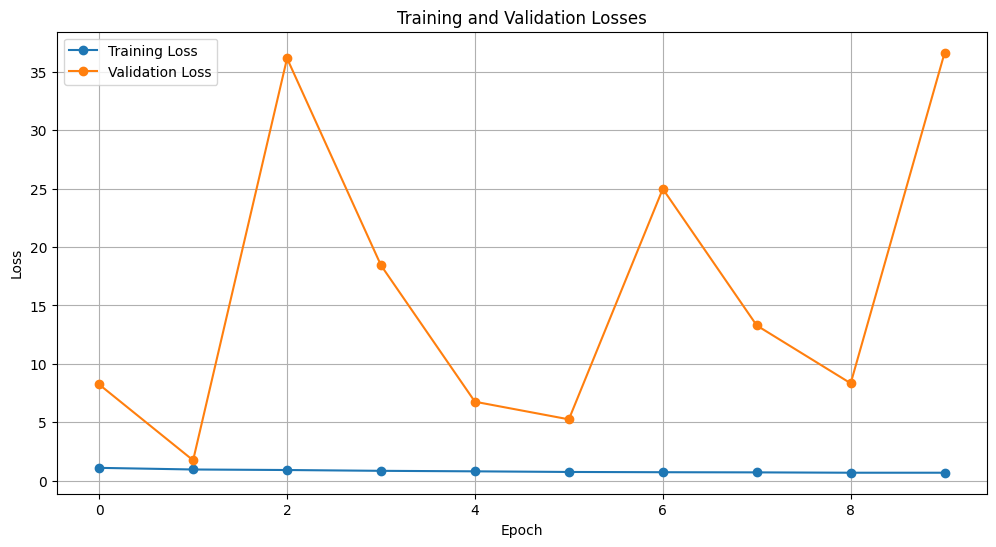

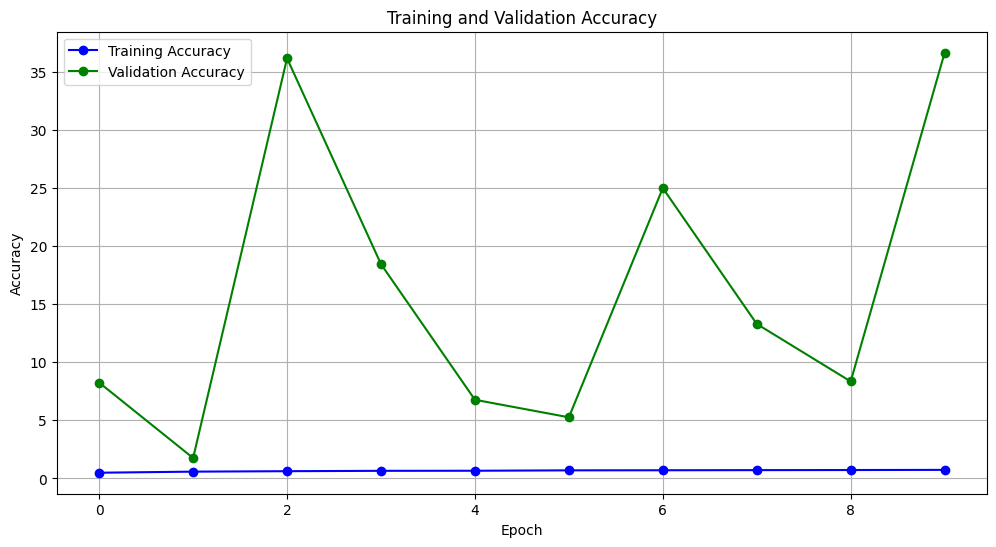

              precision    recall  f1-score   support

         RSC       0.00      0.00      0.00       198
         RSM       0.00      0.00      0.00       138
         TMB       0.26      1.00      0.41       181
      jassid       0.00      0.00      0.00       183

    accuracy                           0.26       700
   macro avg       0.06      0.25      0.10       700
weighted avg       0.07      0.26      0.11       700



/home/idrone2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/idrone2/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


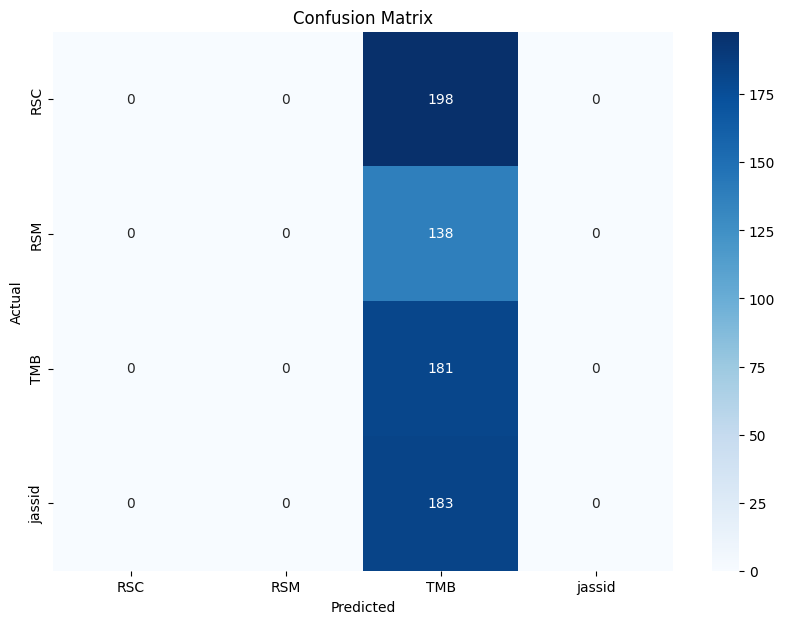

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hybrid_cnn.hybrid_dbsr import RSEEnhancer
from hybrid_cnn import HybridCNN, CustomDBSRDataset, get_dataloaders  # Adjust based on your project structure

# Load data
dataset_loader = '/home/idrone2/Tea_pest/pest_class'
train_loader, test_loader, original_dataset = get_dataloaders(
    folder_path=dataset_loader,
    target_size=(224, 224),
    dbsr_blocks=4,
    batch_size=32,
    augment=True,
    enhance=True,  # Using the enhanced images
    split_ratio=0.8
)

# Initialize the model, loss function, and optimizer
num_classes = len(original_dataset.classes)  # Access classes from the original dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define StepLR scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Adjust step_size and gamma as needed

# Function to calculate validation loss and accuracy
def evaluate_model(model, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            # Store labels and predictions for later evaluation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total

    return avg_loss, accuracy, all_labels, all_preds

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []  # Store training accuracy
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy = correct / total  # Calculate average training accuracy
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)  # Store training accuracy

        # Evaluate on the validation set
        val_loss, val_accuracy, val_labels, val_preds = evaluate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {avg_train_accuracy:.4f}, "  # Print training accuracy
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

        # Step the scheduler
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_losses, val_labels, val_preds

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies, val_labels, val_preds = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=10
)

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy', marker='o', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Print classification report
print(classification_report(val_labels, val_preds, target_names=original_dataset.classes))

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(val_labels, val_preds, classes=original_dataset.classes)
